In [1]:
import numpy as np
import seaborn as sns
import csv
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import patches
import datetime
import math
from numpy.linalg import norm

In [2]:

def calc_xy(phi_deg, lambda_deg, phi0_deg, lambda0_deg):
    """ 緯度経度を平面直角座標に変換する
    # https://qiita.com/sw1227/items/e7a590994ad7dcd0e8ab 参照
    - input:
        (phi_deg, lambda_deg): 変換したい緯度・経度[度]（分・秒でなく小数であることに注意）
        (phi0_deg, lambda0_deg): 平面直角座標系原点の緯度・経度[度]（分・秒でなく小数であることに注意）
    - output:
        x: 変換後の平面直角座標[m]
        y: 変換後の平面直角座標[m]
    """
    # 緯度経度・平面直角座標系原点をラジアンに直す
    phi_rad = np.deg2rad(phi_deg)
    lambda_rad = np.deg2rad(lambda_deg)
    phi0_rad = np.deg2rad(phi0_deg)
    lambda0_rad = np.deg2rad(lambda0_deg)

    # 補助関数
    def A_array(n):
        A0 = 1 + (n**2)/4. + (n**4)/64.
        A1 = -     (3./2)*( n - (n**3)/8. - (n**5)/64. ) 
        A2 =     (15./16)*( n**2 - (n**4)/4. )
        A3 = -   (35./48)*( n**3 - (5./16)*(n**5) )
        A4 =   (315./512)*( n**4 )
        A5 = -(693./1280)*( n**5 )
        return np.array([A0, A1, A2, A3, A4, A5])

    def alpha_array(n):
        a0 = np.nan # dummy
        a1 = (1./2)*n - (2./3)*(n**2) + (5./16)*(n**3) + (41./180)*(n**4) - (127./288)*(n**5)
        a2 = (13./48)*(n**2) - (3./5)*(n**3) + (557./1440)*(n**4) + (281./630)*(n**5)
        a3 = (61./240)*(n**3) - (103./140)*(n**4) + (15061./26880)*(n**5)
        a4 = (49561./161280)*(n**4) - (179./168)*(n**5)
        a5 = (34729./80640)*(n**5)
        return np.array([a0, a1, a2, a3, a4, a5])

    # 定数 (a, F: 世界測地系-測地基準系1980（GRS80）楕円体)
    m0 = 0.9999 
    a = 6378137.
    F = 298.257222101

    # (1) n, A_i, alpha_iの計算
    n = 1. / (2*F - 1)
    A_array = A_array(n)
    alpha_array = alpha_array(n)

    # (2), S, Aの計算
    A_ = ( (m0*a)/(1.+n) )*A_array[0] # [m]
    S_ = ( (m0*a)/(1.+n) )*( A_array[0]*phi0_rad + np.dot(A_array[1:], np.sin(2*phi0_rad*np.arange(1,6))) ) # [m]

    # (3) lambda_c, lambda_sの計算
    lambda_c = np.cos(lambda_rad - lambda0_rad)
    lambda_s = np.sin(lambda_rad - lambda0_rad)

    # (4) t, t_の計算
    t = np.sinh( np.arctanh(np.sin(phi_rad)) - ((2*np.sqrt(n)) / (1+n))*np.arctanh(((2*np.sqrt(n)) / (1+n)) * np.sin(phi_rad)) )
    t_ = np.sqrt(1 + t*t)

    # (5) xi', eta'の計算
    xi2  = np.arctan(t / lambda_c) # [rad]
    eta2 = np.arctanh(lambda_s / t_)

    # (6) x, yの計算
    x = A_ * (xi2 + np.sum(np.multiply(alpha_array[1:],
                                       np.multiply(np.sin(2*xi2*np.arange(1,6)),
                                                   np.cosh(2*eta2*np.arange(1,6)))))) - S_ # [m]
    y = A_ * (eta2 + np.sum(np.multiply(alpha_array[1:],
                                        np.multiply(np.cos(2*xi2*np.arange(1,6)),
                                                    np.sinh(2*eta2*np.arange(1,6)))))) # [m]
    # return
    return y, x # [m]

In [3]:
# プールを基準に距離を作成（プールは50m）
m_0 = (46328.67295324, 69603.73704239)
m_100 = (46287.75853253,  69575.5883232)
np0=np.array([m_0[0], m_0[1]])
np100=np.array([m_100[0], m_100[1]])
distance100m = np.linalg.norm(np0 - np100)
distance1m = distance100m / 100

In [4]:
# プールを基準に距離を作成（プールは50m)
m_0 = (46328.67295324, 69603.73704239)
m_100 = (46287.75853253,  69575.5883232)
np0=np.array([m_0[0], m_0[1]])
np100=np.array([m_100[0], m_100[1]])
distance100m = np.linalg.norm(np0 - np100)
distance1m = distance100m / 100

def read_csv(data_path):
    """ 位置情報の入ったCSVファイルを変換
        google mymap のCSVファイル緯度と経度を読み込む場合に使用
    - input:
        data_path: ファイルの場所
    - output:
        places 緯度と経度が入った配列
    """
    with open(data_path) as f:
        reader = csv.reader(f)
        l = [row for row in reader]

    places = []

    for data in l:
        try:
            data_arr = data[0].replace("(","").replace(")","").split(" ")
            place = (float(data_arr[1])),(float(data_arr[2]))        
            places.append(place)
        except:
            pass

    return places

def coordinate_place(places):
    """ 緯度と経度を座標に変換する
    - input:
        places: 緯度と経度が入った配列・関数read_csvの戻り値
    - output:
        coordinate_places 座標の入った配列
    """
    coordinate_places = []

    for place in places:
        data = calc_xy(place[1], place[0], 35., 138+50./60)
        coordinate_places.append((data[0],data[1]))

    return coordinate_places

def coordinate_place(places):
    """ 緯度と経度を座標に変換する
    - input:
        places: 緯度と経度が入った配列・関数read_csvの戻り値
    - output:
        coordinate_places 座標の入った配列
    """
    coordinate_places = []

    for place in places:
        data = calc_xy(place[1], place[0], 35., 138+50./60)
        coordinate_places.append((data[0],data[1]))

    return coordinate_places

def calc_min_max(data):
    """ 座標の最小値と最大値を出す。
    - input:
        data: 座標の入った配列・関数coordinate_placeの戻り値
    - output:
        return_taple: x座標の最大値と最小値、y座標の最小値と最大値
    """
    x_max = data[0][0]
    x_min = data[0][0]
    y_max = data[0][1]
    y_min = data[0][1]

    for i in data:
        if(x_max <= i[0]):
            x_max = i[0]
        if(x_min >= i[0]):
            x_min = i[0]
        if(y_max <= i[1]):
            y_max = i[1]
        if(y_min >= i[1]):
            y_min = i[1]

    return_taple = (x_max,x_min,y_max,y_min)
    return return_taple

def read_load_csv(data_path):
    """ 道情報の入ったCSVファイルを読み込む
        google mymap のCSVファイル緯度と経度を読み込む場合に使用
    - input:
        data_path: ファイルの場所
    - output:
        places 
    """
    with open(data_path) as f:
        reader = csv.reader(f)
        l = [row for row in reader]

    tut_map_data = {} 

    # google mymap から書き出したCSVを変換
    # 形式は "POINT (139.3377123 35.6276553)",ポイント 1,2
    #       "POINT ([緯度] [経度])",ポイント [自分の番号],[接続先の番号]
    for data in l:
        if("POINT" in data[0]):
            data_arr = data[0].replace("(","").replace(")","").split(" ")
            point_number = int(data[1].split(" ")[1])
            connection_numbers = []
            for number_str in data[2].split("-"):
                try:
                    connection_numbers.append(int(number_str))
                except:
                    pass
            place = (float(data_arr[1])),(float(data_arr[2]))     
            coordinate = calc_xy(float(data_arr[2]), float(data_arr[1]), 35., 138+50./60)
            
            tut_map_data[point_number] = place,coordinate,connection_numbers

    
    # 接続先の接続ポイント情報にも、自分のポイントを入れる
    for subscript in tut_map_data:
        for connection_subscript in tut_map_data[subscript][2]:
            if not subscript in tut_map_data[connection_subscript][2]:
                tut_map_data[connection_subscript][2].append(subscript)

    return tut_map_data

def visualization_tut_map(fig,ax):
    """ TUTの衛星写真を表示
    - input:
        fig,ax : グラフ表示用
        road_data: 地図情報
    - output:
        fig,ax : グラフ表示用
    """
    # TUTの地図
    places = read_csv("tut.csv")
    coordinate_places = coordinate_place(places)
    x_max,x_min,y_max,y_min = calc_min_max(coordinate_places)
    im = Image.open("tut_map2.png")
    im_list = np.asarray(im)
    plt.imshow(im_list, extent = [x_min - 50, x_max + 50, y_min - 50, y_max + 50])

    # グラフ関係
    #plt.xlim(x_min - 70, x_max + 70)
    #plt.ylim(y_min - 70, y_max + 70)
    plt.tick_params(labelsize=0)

    return fig,ax


def visualization_road(fig,ax,road_data):
    """ 道路を表示
    - input:
        fig,ax : グラフ表示用
        road_data: 道のデータ
    - output:
        fig,ax : グラフ表示用
    """
    for subscript in road_data:
        plt.scatter(road_data[subscript][1][0], road_data[subscript][1][1], color="orange" ,s=50)
        plt.text(road_data[subscript][1][0], road_data[subscript][1][1] + 5, str(subscript), fontsize=16)
        
        for connection_numbers in road_data[subscript][2]:
            if(subscript < connection_numbers):
                pass
                plt.plot((road_data[subscript][1][0],road_data[connection_numbers][1][0]),(road_data[subscript][1][1],road_data[connection_numbers][1][1]),color="orange",lw=3,zorder=1)

    return fig,ax

def calc_distance_and_neighbor_point(coordinate_a, coordinate_b, coordinate_p):
    """ 最近傍点の算出
        座標aと座標bを結んだ線上でpに一番近い座標を最近傍点という
    - input:
        coordinate_a : 座標a (x,y)のタプル
        coordinate_b : 座標b (x,y)のタプル
        coordinate_p : 座標p (x,y)のタプル
    - output:
        neighbor_point.tolist() : 最近傍点の座標 (x,y)のタプル
        distance : 最近傍点と座標pの距離
    """
    a = np.array([coordinate_a[0],coordinate_a[1]])
    b = np.array([coordinate_b[0],coordinate_b[1]])
    p = np.array([coordinate_p[0],coordinate_p[1]])
    
    ap = p - a
    ab = b - a
    ba = a - b
    bp = p - b
    if np.dot(ap, ab) < 0:
        distance = norm(ap)
        neighbor_point = a
    elif np.dot(bp, ba) < 0:
        distance = norm(p - b)
        neighbor_point = b
    else:
        ai_norm = np.dot(ap, ab)/norm(ab)
        neighbor_point = a + (ab)/norm(ab)*ai_norm
        distance = norm(p - neighbor_point)
        #print(f"IN a:{coordinate_a} b:{coordinate_b} c:{coordinate_p} OUT:{neighbor_point.tolist()}")
    return neighbor_point.tolist(), distance

def map_mapping(fig,ax,location,road_data):
    """ 道路に沿って位置の修正
    - input:
        road_data : 道データ
        location : (緯度,経度)の入ったタプル
    - output:
        new_xy : マップマッピング後の座標
        neighbor_point_subscript: 最近傍点を取る際に使用した直線の添字のタプル
    """
    # 元の位置情報を座標に変換
    xy = calc_xy(location[0], location[1], 35., 138+50./60)

    # 道データを一番近い順に取得
    neighbor_point_data = [] #最近傍点の座標と距離が入る
    for point_a_subscript in road_data: #すべて回すのは無駄な処理が多いなぁ・・・(とりあえず動いてるからいいか！)
        for point_b_subscript in road_data[point_a_subscript][2]: #座標に一番近い道路情報の接続している添字
            coordinate_a = road_data[point_a_subscript][1]
            coordinate_b = road_data[point_b_subscript][1]
            coordinate_p = xy
            neighbor_point,distance = calc_distance_and_neighbor_point(coordinate_a, coordinate_b, coordinate_p)
            neighbor_point_data.append((neighbor_point,distance,(point_a_subscript,point_b_subscript)))

    neighbor_point_data = sorted(neighbor_point_data, key=lambda x:(x[1]))
    new_xy = (neighbor_point_data[0][0][0], neighbor_point_data[0][0][1])
    neighbor_point_subscript = neighbor_point_data[0][2]
    return fig,ax,new_xy,neighbor_point_subscript

def calc_distance(coordinate1,coordinate2):
    """ 2点間の距離を計算
    - input:
        coordinate1 : (x,y)のタプル
        coordinate2 : (x,y)のタプル
    - output:
        distance : 2点間の距離
    """
    a = np.array([coordinate1[0],coordinate1[1]])
    b = np.array([coordinate2[0],coordinate2[1]])
    distance=np.linalg.norm(b-a)
    return distance

def load_test_data(file_path):
    """ 測位した位置情報の入ったCSVファイルを配列に変換
    - input:
        data_path: ファイルの場所
    - output:
        test_data: 変換された配列
    """
    with open(file_path) as f:
        reader = csv.reader(f)
        l = [row for row in reader]

    places = []

    for data in l:
        try:
            places.append((data[0],data[1],float(data[2]),float(data[3]),float(data[4]),float(data[5]),float(data[6])))
        except:
            pass

    return places
    
def direction_of_travel(fig,ax,road_data,coordinate,neighbor_point_subscript,angle):
    """ 地磁気センサからどちらの方向へ進んでいるか調べる
    - input:
        fig,ax : グラフ表示用
        road_data : 地図情報
        coordinate : 初期位置の座標タプル(x,y)
        neighbor_point_subscript: 2点の添字が入ったタプル
        angle : 地磁気センサの角度
    - output:
        fig,ax : グラフ表示用
        go_to_subscript : 向かっている方向の添字
        back_to_subscript : どこから向かっていたか
    """
    # 座標を少し移動させる
    move = 50
    now_x = coordinate[0]
    now_y = coordinate[1]
    move_x = now_x + move * np.sin(angle * (np.pi / 180))
    move_y = now_y + move * np.cos(angle * (np.pi / 180))

    point_a_data = road_data[neighbor_point_subscript[0]]
    point_b_data = road_data[neighbor_point_subscript[1]]

    # 距離の変位を計算
    calc_data = [] # 移動させた時の距離の変位を入れる
    calc_data.append((neighbor_point_subscript[0] , calc_distance(road_data[neighbor_point_subscript[0]][1],(move_x,move_y)) - calc_distance(road_data[neighbor_point_subscript[0]][1],(now_x,now_y)) ))# 移動させた後のとの距離 - 移動させる前との距離
    calc_data.append((neighbor_point_subscript[1] , calc_distance(road_data[neighbor_point_subscript[1]][1],(move_x,move_y)) - calc_distance(road_data[neighbor_point_subscript[1]][1],(now_x,now_y)) ))# 移動させた後のとの距離 - 移動させる前との距離
    #plt.quiver(now_x, now_y, move_x-now_x, move_y-now_y, width=0.002, scale_units='xy', scale=1) #地磁気センサのアングルを表示
  
    # 距離の変位からどちらに向かってるか求める
    go_to_subscript = -1
    back_to_subscript = -1
    if(calc_data[0][1] < calc_data[1][1]): 
        go_to_subscript = calc_data[0][0]
        back_to_subscript = calc_data[1][0]
    if(calc_data[0][1] > calc_data[1][1]): 
        go_to_subscript = calc_data[1][0]
        back_to_subscript = calc_data[0][0]
    
    # 向かう交差点へ矢印を表示
    goto_x = road_data[go_to_subscript][1][0]
    goto_y = road_data[go_to_subscript][1][1]
    #plt.quiver(now_x, now_y, goto_x-now_x, goto_y-now_y, width=0.004, scale_units='xy', scale=1) #地磁気センサのアングルを表示
    #print(f"{calc_data} →{go_to_subscript}")
    return fig,ax,back_to_subscript,go_to_subscript

def predict(fig,ax,road_data,route_data,angle,sec,speed,coordinate,back_to_subscript,go_to_subscript):
    """ 位置情報を予測し、予測した座標を返却
    - input:
        fig,ax : グラフ表示用
        road_data : 地図情報
        route_data : 通った道路の情報が入っている
        angle : 地磁気センサの角度
        sec : 位置情報と地磁気センサを取得した秒数
        coordinate : 最近傍点で求めた初期位置の座標タプル(x,y)
        back_to_subscript : どこから向かったか
        go_to_subscript : どこの点に向かっているか（進行方向） 
        speed:速度

    - output:
        fig,ax : グラフ表示用
        new_coordinate : 座標 交差点を通る際に情報がなければ-1
    """
    #print(f"スタート地点:{back_to_subscript}と{go_to_subscript}の間で{go_to_subscript}へ向かう")
    new_coordinate = (-1,-1)
    
    interval_time = 60 - sec # 実際に使用する時はこっち
    #interval_time = 90 - sec # デバック用
    move = (speed * 1000) / 3600 * interval_time

    # 初期位置からの直線予測
    line_predict_x = coordinate[0] + move * np.sin(angle * (np.pi / 180))
    line_predict_y = coordinate[1] + move * np.cos(angle * (np.pi / 180))
    plt.quiver(coordinate[0], coordinate[1], line_predict_x-coordinate[0], line_predict_y-coordinate[1], width=0.004, scale_units='xy', scale=1, color="red")

    if(calc_distance(coordinate,road_data[go_to_subscript][1]) > move):
        # 移動させた時、次の道データの点に達しない場合 → 移動させて終了
        c_x = road_data[go_to_subscript][1][0] - coordinate[0]
        c_y = road_data[go_to_subscript][1][1] - coordinate[1]
        rad = np.arctan2(c_y , c_x)

        new_x = coordinate[0] + move * np.cos(rad)
        new_y = coordinate[1] + move * np.sin(rad)
        new_coordinate = (new_x,new_y)
        plt.quiver(coordinate[0], coordinate[1], new_coordinate[0]-coordinate[0], new_coordinate[1]-coordinate[1], width=0.004, scale_units='xy', scale=1, zorder=4)
        #print("交差点・曲がり角に達する前に終了")
        return fig,ax,new_coordinate
    else:
        # とりあえず曲がり点まで移動
        temporary_subscript = go_to_subscript # 一時的な添字
        temporary_old_subscript = back_to_subscript # 一時的な添字
        temporary_x = road_data[go_to_subscript][1][0] # 一時的なx
        temporary_y = road_data[go_to_subscript][1][1] # 一時的なy
        move = move - calc_distance(coordinate,road_data[go_to_subscript][1])

        plt.quiver(coordinate[0], coordinate[1], temporary_x-coordinate[0], temporary_y-coordinate[1], width=0.004, scale_units='xy', scale=1, zorder=4)

        cnt = 0
        while move > 0: # 後でこっちに変更
            #print(f"現在の作業交差点:{temporary_subscript}")
            cnt += 1
            if(cnt >= 10): # 10回の曲がり角・交差点で処理を終了
                new_coordinate = (-1,-1)
                return fig,ax,new_coordinate
            if(len(road_data[temporary_subscript][2]) == 2): # 交差点か曲がり点か？
                #曲がり角の作業
                #print(f"{temporary_subscript}は曲がり角")
                for i in road_data[temporary_subscript][2]:
                    if(not i == temporary_old_subscript):
                        go_to_subscript = i
                #print(f"曲がり角{temporary_subscript}から{go_to_subscript}の方面へ移動")
                if(calc_distance(road_data[temporary_subscript][1],road_data[go_to_subscript][1]) > move):
                    # 移動させた時、次の道データの点に達しない場合 → 移動させて終了
                    c_x = road_data[go_to_subscript][1][0] - road_data[temporary_subscript][1][0]
                    c_y = road_data[go_to_subscript][1][1] - road_data[temporary_subscript][1][1]
                    rad = np.arctan2(c_y , c_x)


                    now_x = road_data[temporary_subscript][1][0]
                    now_y = road_data[temporary_subscript][1][1]
                    new_x = now_x + move * np.cos(rad)
                    new_y = now_y + move * np.sin(rad)
                    new_coordinate = (new_x,new_y)
                    plt.quiver(now_x, now_y, new_x-now_x, new_y-now_y, width=0.004, scale_units='xy', scale=1, zorder=4)
                    return fig,ax,new_coordinate
                else:
                    # 移動させた時、次の道データの点に達している時 → 距離と添字を変更させて次へ
                    move = move - calc_distance(road_data[temporary_subscript][1],road_data[go_to_subscript][1])

                    plt.quiver(road_data[temporary_subscript][1][0], road_data[temporary_subscript][1][1], road_data[go_to_subscript][1][0]-road_data[temporary_subscript][1][0], road_data[go_to_subscript][1][1]-road_data[temporary_subscript][1][1], width=0.004, scale_units='xy', scale=1, zorder=4)
                    temporary_old_subscript = temporary_subscript
                    temporary_subscript = go_to_subscript
                    #print(move)
                        
            elif(len(road_data[temporary_subscript][2]) > 2):
                #交差点
                #print(f"{temporary_subscript}は交差点")
                including_intersections_route_data = {}
                for i in route_data:
                    #print(f"{i[0]} == {temporary_subscript} and ({i[1]} == {temporary_old_subscript} or {i[2]} == {temporary_old_subscript})")
                    if(i[0] == temporary_subscript and (i[1] == temporary_old_subscript or i[2] == temporary_old_subscript)):
                        # 現在いる交差点の通過情報だけを抽出、その時、来た場所の添字を含まない通過情報は排除
                        including_intersections_route_data[i] = route_data[i]
                if(len(including_intersections_route_data)<=0):
                    #  通過情報が無い場合 終了
                    new_coordinate = (-1,-1)
                    #print(f"{temporary_subscript}の通過情報が無いので終了")
                    return fig,ax,new_coordinate
                including_intersections_route_data = sorted(including_intersections_route_data.items(), key=lambda x:x[0])
                use_intersections_route_data = list(including_intersections_route_data)[0][0]

                if(use_intersections_route_data[1] == temporary_old_subscript): go_to_subscript = use_intersections_route_data[2]
                if(use_intersections_route_data[2] == temporary_old_subscript): go_to_subscript = use_intersections_route_data[1]

                #print(f"**** 交差点{temporary_subscript}から{go_to_subscript}の方面へ移動 ***")
                #print(f"temporary_subscript {temporary_old_subscript}")
                #print(f"use_intersections_route_data {use_intersections_route_data}")
                #print(f"go_to_subscript {go_to_subscript}")
                #print()

                if(calc_distance(road_data[temporary_subscript][1],road_data[go_to_subscript][1]) > move):
                    # 移動させた時、次の道データの点に達しない場合 → 移動させて終了
                    c_x = road_data[go_to_subscript][1][0] - road_data[temporary_subscript][1][0]
                    c_y = road_data[go_to_subscript][1][1] - road_data[temporary_subscript][1][1]
                    rad = np.arctan2(c_y , c_x)
                    now_x = road_data[temporary_subscript][1][0]
                    now_y = road_data[temporary_subscript][1][1]
                    new_x = now_x + move * np.cos(rad)
                    new_y = now_y + move * np.sin(rad)
                    new_coordinate = (new_x,new_y)
                    plt.quiver(now_x, now_y, new_x-now_x, new_y-now_y, width=0.004, scale_units='xy', scale=1, zorder=4)
                    return fig,ax,new_coordinate
                else:
                    # 移動させた時、次の道データの点に達している時 → 距離と添字を変更させて次へ
                    move = move - calc_distance(road_data[temporary_subscript][1],road_data[go_to_subscript][1])

                    plt.quiver(road_data[temporary_subscript][1][0], road_data[temporary_subscript][1][1], road_data[go_to_subscript][1][0]-road_data[temporary_subscript][1][0], road_data[go_to_subscript][1][1]-road_data[temporary_subscript][1][1], width=0.004, scale_units='xy', scale=1, zorder=4)
                    temporary_old_subscript = temporary_subscript
                    temporary_subscript = go_to_subscript

            elif(len(road_data[temporary_subscript][2]) == 1):
                #print(f"{temporary_subscript}は終端")
                new_x = road_data[temporary_subscript][1][0]
                new_y = road_data[temporary_subscript][1][1]
                new_coordinate = (new_x,new_y)
                return fig,ax,new_coordinate

In [5]:
def visualization_tut_map(fig,ax):
    """ TUTの衛星写真を表示
    - input:
        fig,ax : グラフ表示用
        road_data: 地図情報
    - output:
        fig,ax : グラフ表示用
    """
    # TUTの地図
    places = read_csv("tut.csv")
    coordinate_places = coordinate_place(places)
    x_max,x_min,y_max,y_min = calc_min_max(coordinate_places)
    im = Image.open("tut_map2.png")
    im_list = np.asarray(im)
    plt.imshow(im_list, extent = [x_min - 50, x_max + 50, y_min - 50, y_max + 50])

    # グラフ関係
    plt.xlim(x_min - 70, x_max + 70)
    plt.ylim(y_min - 70, y_max + 70)
    plt.tick_params(labelsize=0)

    return fig,ax

def map_init(title):
    """ マップの初期化
    - input:
        title : グラフタイトル
    - output:
        fig,ax : グラフ表示用
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    plt.rcParams["font.size"] = 10
    plt.rcParams['font.family'] = 'Times New Roman'
    plt.title(f"{title}",fontfamily='Meiryo')
    fig, ax = visualization_tut_map(fig,ax)
    tut_road_data = read_load_csv(data_path="tut_map_data.csv")
    fig, ax = visualization_road(fig,ax,tut_road_data)
    return fig,ax

def communicable_number_predict(next_place_data,communication_range):
    """ 予測した座標を使用してBLE通信できる機器の台数を求める
    - input:
        next_place_data: (id,座標x,座標y)を格納したタプル
        communication_range: 通信半径[m]
    - output:
        arr: 機器IDを添え字、通信可能台数を格納した連想配列
    """
    radius = distance1m * 2 * communication_range
    
    arr={}
    for i in next_place_data:
        cnt=-1
        for j in next_place_data:
            a=np.array([i[1],i[2]])
            b=np.array([j[1],j[2]])
            distance=np.linalg.norm(b-a)
            if(radius >= distance):
                cnt += 1
        arr[i[0]] = cnt
    return arr

tut_road_data = read_load_csv(data_path="tut_map_data.csv")

def communicable_number_show(fig,ax,communicable_number_data,predicted_position_arr,communication_range):
    """ マップに通信可能台数と重複数を表示
    - input:
        fig,ax : グラフ表示用
        communicable_number_data : keyにID , Valueに通信可能予測台数を入れたディクショナリ
        predicted_position_arr : (id,x座標,y座標)のタプルを格納した配列 予測終了後のデータを入れてある
        communication_range : 通信範囲
    - output:
        fig,ax : グラフ表示用
    """
    # 予測通信可能台数表示
    radius = distance1m * 2 * communication_range
    for predicted_position in predicted_position_arr:
        patch = patches.Circle(xy=(predicted_position[1], predicted_position[2]), radius=radius, ec="purple", fc="none", linestyle="--", linewidth="2")
        ax.add_patch(patch)
        plt.text(predicted_position[1], predicted_position[2] + radius, f"通{communicable_number_data[predicted_position[0]]}", fontsize=16, color="purple", fontfamily='Meiryo', backgroundcolor='white')

    # 重複の表示
    for i in predicted_position_arr:
        cnt = -1
        for j in predicted_position_arr:
            if(i[1]==j[1] and i[2]==j[2]):
                cnt += 1
        plt.text(i[1], i[2] + radius - 30, f"重{cnt}", fontsize=16, color="purple", fontfamily='Meiryo', backgroundcolor='white')
        
    return fig,ax


In [6]:
def experiment_calc(title,communication_range,route_data_arr,gps_data):
    fig,ax = map_init(title)
    predicted_position_arr = []

    for subscript in gps_data:
        if(subscript in route_data_arr and subscript in gps_data):
            if(len(gps_data[subscript]) == 5):
                xy = calc_xy(gps_data[subscript][1], gps_data[subscript][2], 35., 138+50./60)
                plt.scatter(xy[0], xy[1], color="blue" ,s=50 ,zorder=2)
                fig,ax,new_xy,neighbor_point_subscript = map_mapping(fig,ax,(gps_data[subscript][1], gps_data[subscript][2]),tut_road_data)
                plt.scatter(new_xy[0], new_xy[1], color="red" ,s=50 ,zorder=3)
                angle = gps_data[subscript][4]
                fig,ax,back_to_subscript,go_to_subscript = direction_of_travel(fig,ax,tut_road_data,new_xy,neighbor_point_subscript,angle)
                
                sec = gps_data[subscript][0]
                speed = gps_data[subscript][3]
                fig,ax,new_coordinate = predict(fig,ax,tut_road_data,route_data_arr[subscript],angle,sec,speed,new_xy,back_to_subscript,go_to_subscript)
                if(not new_coordinate[0] == -1):
                    plt.plot(new_coordinate[0],new_coordinate[1],"o",alpha=1,color="green",label="予測地点",zorder=3)
                    predicted_position_arr.append((subscript,new_coordinate[0],new_coordinate[1]))
                else:
                    print(f"{subscript}はGPS測位")

    communicable_number_data = communicable_number_predict(predicted_position_arr,communication_range)
    communicable_number_show(fig,ax,communicable_number_data,predicted_position_arr,communication_range)
    print(communicable_number_data)
    plt.show()

# 実験計算の書き方

In [7]:
# パラメータ
communication_range = 100

テストデータ
{1: 0, 2: 1, 5: 1}


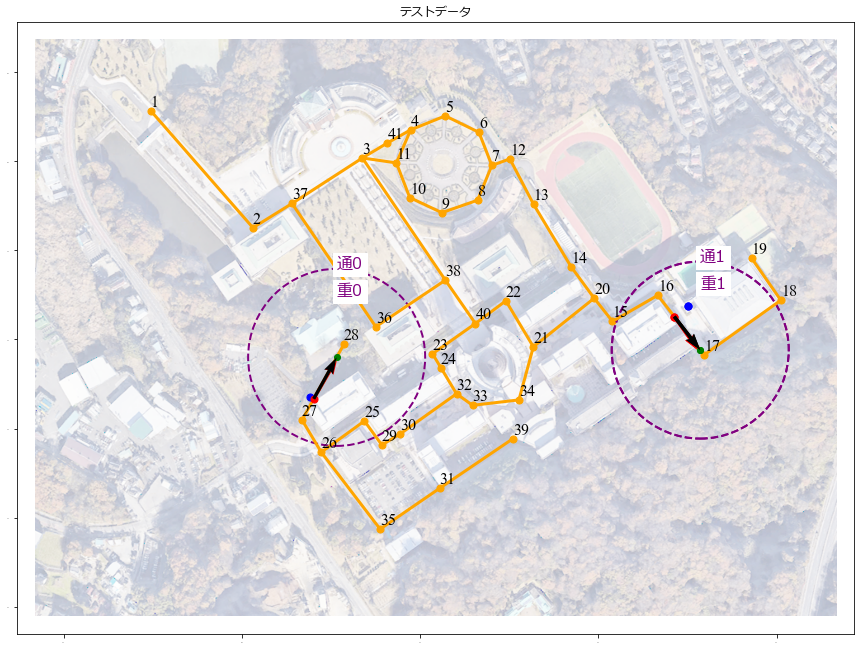

In [9]:
title = "テストデータ"

# ルート情報を入力
route_data_arr = {}      
route_data_arr[1] = {(37,2,36):1, (3,37,38):1, (38,3,40):1, (40,38,23):1, (32,24,30):1, (26,25,27):1}   
route_data_arr[2] = {}
route_data_arr[3] = {}
route_data_arr[4] = {}
route_data_arr[5] = {}
route_data_arr[6] = {}

# 測位情報を入力
# (sec,lon,lat,speed,angle)
gps_data = {}
gps_data[1] = (25,35.62485,139.3398,5.47,30.13) 
gps_data[2] = (25,35.62575,139.3445,4.89,144.42)
gps_data[3] = ()
gps_data[4] = ()
gps_data[5] = (25,35.62575,139.3445,4.89,144.42)
gps_data[6] = ()

print(title)
experiment_calc(title,communication_range,route_data_arr,gps_data)